In [1]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from keras import layers
from keras import losses

In [2]:
np.set_printoptions(precision=3, suppress=True)
#Preprocess Datsets
def preprocess(ratings):
  ratings_features=ratings.copy()
  ratings_labels=ratings_features.pop("reviews.rating")
  inputs={}
  for name, column in ratings_features.items():
    dtype = column.dtype
    if dtype == object:
      dtype = tf.string
    else:
      dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)


  preprocessed_inputs = []
  for name, input in inputs.items():
    if input.dtype == tf.float32:
      continue
    lookup = layers.StringLookup(vocabulary=np.unique(ratings_features[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)
    preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

  ratings_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)
  ratings_features_l=[]
  for name, value in ratings_features.items():
    ratings_features_l.append(np.array(value))
  ratings_features_dict = {name: np.array(value)
                            for name, value in ratings_features.items()}
  ratings_features_l=np.array(ratings_features_dict['reviews.text'])
  features_l=[ratings_features_dict['reviews.text'][:1]]
  ratings_preprocessing(features_l)
  def ratings_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
      layers.Dense(64),
      layers.Dense(5)
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(loss= tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam())
    return model

  ratings_model = ratings_model(ratings_preprocessing, inputs)
  #ratings_model.fit(x=ratings_features_l, y=ratings_labels, epochs=10)
  ratings_ds = tf.data.Dataset.from_tensor_slices((ratings_features_l, ratings_labels))
  train_ds = ratings_ds.shuffle(len(ratings_labels)).batch(32)
  ratings_model.fit(train_ds, epochs=5)


  return train_ds




In [12]:
#Training Dataset
ratings_train = pd.read_csv("train_1.csv")
raw_train_ds=preprocess(ratings_train)

Epoch 1/5
938/938 [==============================] - 8s 8ms/step - loss: 2.2710
Epoch 2/5
938/938 [==============================] - 7s 8ms/step - loss: 1.1619
Epoch 3/5
938/938 [==============================] - 7s 8ms/step - loss: 0.2119
Epoch 4/5
938/938 [==============================] - 8s 8ms/step - loss: 0.1459
Epoch 5/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0895


In [13]:
#Testing Dataset
ratings_test=pd.read_csv('test_1.csv')
raw_test_ds=preprocess(ratings_test)

Epoch 1/5
923/923 [==============================] - 9s 8ms/step - loss: 2.2106
Epoch 2/5
923/923 [==============================] - 6s 6ms/step - loss: 1.1778
Epoch 3/5
923/923 [==============================] - 6s 7ms/step - loss: 0.2172
Epoch 4/5
923/923 [==============================] - 7s 7ms/step - loss: 0.1434
Epoch 5/5
923/923 [==============================] - 6s 7ms/step - loss: 0.0903


In [14]:
#Validation Dataset
ratings_val=pd.read_csv("val_1.csv")
raw_val_ds=preprocess(ratings_val)

Epoch 1/5
185/185 [==============================] - 1s 4ms/step - loss: 3.2245
Epoch 2/5
185/185 [==============================] - 1s 3ms/step - loss: 1.7080
Epoch 3/5
185/185 [==============================] - 1s 3ms/step - loss: 1.2537
Epoch 4/5
185/185 [==============================] - 1s 3ms/step - loss: 0.6870
Epoch 5/5
185/185 [==============================] - 1s 3ms/step - loss: 0.2239


In [15]:
#Loading The Preprocessed Datasets
raw_train_ds = tf.data.Dataset.load('raw_train_ds.tfds')
raw_val_ds = tf.data.Dataset.load('raw_val_ds.tfds')
raw_test_ds = tf.data.Dataset.load('raw_test_ds.tfds')

In [16]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label
#Declaring the model
embedding_dim = 16
model = tf.keras.Sequential([
  vectorize_layer,
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(5,activation='softmax')])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),optimizer='adam',metrics=['accuracy'])



In [5]:
epochs = 10
history = model.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    epochs=epochs)

Epoch 1/10

938/938 [==============================] - 7s 7ms/step - loss: 1.5963 - accuracy: 0.2497 - val_loss: 1.5935 - val_accuracy: 0.2354
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 1.5513 - accuracy: 0.3027 - val_loss: 1.5305 - val_accuracy: 0.2882
Epoch 3/10
938/938 [==============================] - 5s 6ms/step - loss: 1.4800 - accuracy: 0.3479 - val_loss: 1.4684 - val_accuracy: 0.3165
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 1.4213 - accuracy: 0.3737 - val_loss: 1.4294 - val_accuracy: 0.3232
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 1.3813 - accuracy: 0.3860 - val_loss: 1.4065 - val_accuracy: 0.3267
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 1.3513 - accuracy: 0.3963 - val_loss: 1.3921 - val_accuracy: 0.3277
Epoch 7/10
938/938 [==============================] - 5s 6ms/step - loss: 1.3285 - accuracy: 0.4089 - val_loss: 1.3838 - val_accuracy: 0.3293
Epoch

In [10]:
model.save('sa_model.keras')

In [6]:
loss, accuracy = model.evaluate(raw_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

938/938 [==============================] - 3s 3ms/step - loss: 1.3757 - accuracy: 0.3300
Loss:  1.3757010698318481
Accuracy:  0.32996734976768494


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


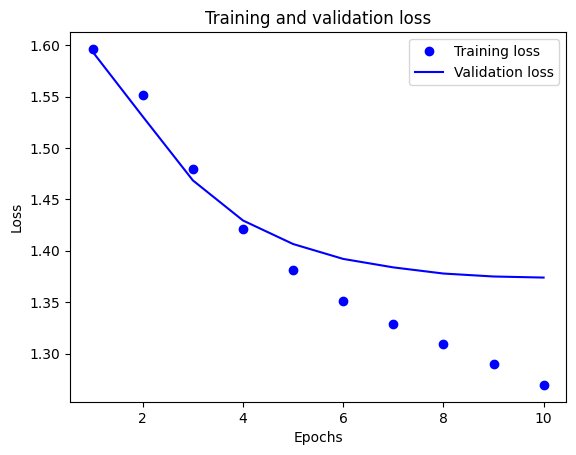

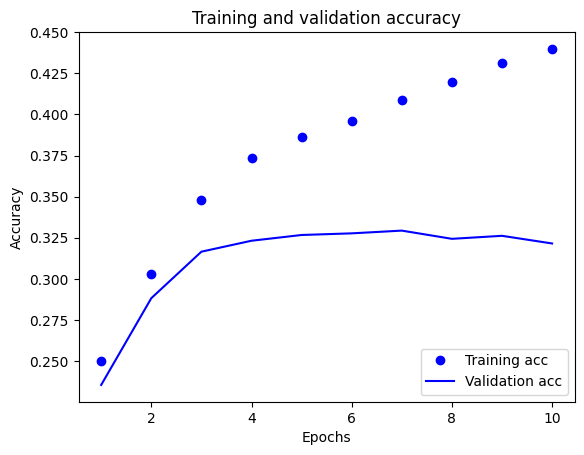

In [7]:
history_dict = history.history
print(history_dict.keys())
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


In [11]:
examples = [
  '''The quality of clothes here is appropriate. You know, when you need some denim jackets, jeans or other stuff, you can easily attend any affiliate of this company and buy whatever you want.
    You will be happy about the apparel quality, however, it's not a top segment.
    Still, this company continues to be irreplaceable for me in case I need to fill up by wardrobe.
''',
'''Disaster'''
]
l=list(model.predict(examples))
x=0
for i in l:
  x+=1
  i=list(i)
  maxpos = i.index(max(i))
  print(f"The sentiment is:{(maxpos+1)}")

1/1 [==============================] - 0s 59ms/step
The sentiment is:5
The sentiment is:1
